In [ ]:
import torch.nn as nn
import torch
from layers import *

class DetectionModel(nn.Module):
    def __init__(self, depth=0.5, width=0.25, max_channels=1024, nc=80):
        """
        Initialize the DetectionModel.

        Args:
            depth (float): Depth multiplier for scaling the model.
            width (float): Width multiplier for scaling the model.
            max_channels (int): Maximum number of channels.
            nc (int): Number of classes for detection.
        """
        super().__init__()

        # Backbone
        self.model = nn.Sequential(
            Conv(3, int(64 * width), 3, 2),  # 0-P1/2
            Conv(int(64 * width), int(128 * width), 3, 2),  # 1-P2/4
            C3k2(int(128 * width), int(256 * width), n=int(2 * depth), c3k=False, e=0.25),
            Conv(int(256 * width), int(256 * width), 3, 2),  # 3-P3/8
            C3k2(int(256 * width), int(512 * width), n=int(2 * depth), c3k=False, e=0.25),
            ##
            Conv(int(512 * width), int(512 * width), 3, 2),  # 5-P4/16
            C3k2(int(512 * width), int(512 * width), n=int(2 * depth), c3k=True),
            ##
            Conv(int(512 * width), int(1024 * width), 3, 2),  # 7-P5/32
            C3k2(int(1024 * width), int(1024 * width), n=int(2 * depth), c3k=True),
            SPPF(int(1024 * width), int(1024 * width), k=5),  # 9
            C2PSA(int(1024 * width), int(1024 * width), n=int(2 * depth)),
            )  # 10
            # Head
        self.neck = nn.Sequential(
            nn.Upsample(scale_factor=2, mode="nearest"),  # -1 
            Concat(dimension=1),  # cat backbone P4
            C3k2(int(1536 * width), int(512 * width), n=int(2 * depth), c3k=False),  # 13

            nn.Upsample(scale_factor=2, mode="nearest"),  # -1
            Concat(dimension=1),  # cat backbone P3
            C3k2(int(1024 * width), int(256 * width), n=int(2 * depth), c3k=False),  # 16 (P3/8-small)

            Conv(int(256 * width), int(256 * width), 3, 2),  # -1
            Concat(dimension=1),  # cat head P4
            C3k2(int(768 * width), int(512 * width), n=int(2 * depth), c3k=False),  # 19 (P4/16-medium)

            Conv(int(512 * width), int(512 * width), 3, 2),  # -1
            Concat(dimension=1),  # cat head P5
            C3k2(int(1536 * width), int(1024 * width), n=int(2 * depth), c3k=True),  # 22 (P5/32-large)
        )

        self.head = Detect(nc=nc, ch=[int(256 * width), int(512 * width), int(1024 * width)])  # Detect(P3, P4, P5)

    def forward(self, x):
        """
        Forward pass through the DetectionModel.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            (torch.Tensor): Output tensor.
        """
        x_out = []
        for n, layer in enumerate(self.model):
            x = layer(x)
            if n==4 or n==6:
                x_out.append(x)
        x_out.append(x)
        p4, p6, p10 = x_out

        for n, layer in enumerate(self.neck):
            
            if n==1 and isinstance(layer, Concat):
                x = layer((x, p6))

            elif n==4 and isinstance(layer, Concat):
                x = layer((x, p4))

            elif n==7 and isinstance(layer, Concat):
                x = layer((x, p12))
                
            elif n==10 and isinstance(layer, Concat):
                x = layer((x, p10))

            elif n==2 and isinstance(layer, C3k2):
                x = layer(x)
                p12 = x.clone()

            elif n==5 and isinstance(layer, C3k2):
                x = layer(x)
                p14 = x.clone()

            elif n==8 and isinstance(layer, C3k2):
                x = layer(x)
                p17 = x.clone()
                
            
            else:
                x = layer(x)
        print(x.shape, p14.shape, p17.shape)
        # x = self.head([x,p14,p17])
        return x

In [40]:
import torch.nn as nn
import torch
from layers import *

class DetectionModel(nn.Module):
    def __init__(self, depth=0.5, width=0.25, max_channels=1024, nc=80):
        """
        Initialize the DetectionModel.

        Args:
            depth (float): Depth multiplier for scaling the model.
            width (float): Width multiplier for scaling the model.
            max_channels (int): Maximum number of channels.
            nc (int): Number of classes for detection.
        """
        super().__init__()

        # Backbone
        self.model = nn.Sequential(
            Conv(3, int(64 * width), 3, 2),  # 0-P1/2
            Conv(int(64 * width), int(128 * width), 3, 2),  # 1-P2/4
            C3k2(int(128 * width), int(256 * width), n=int(2 * depth), c3k=False, e=0.25),
            Conv(int(256 * width), int(256 * width), 3, 2),  # 3-P3/8
            C3k2(int(256 * width), int(512 * width), n=int(2 * depth), c3k=False, e=0.25),
            ##
            Conv(int(512 * width), int(512 * width), 3, 2),  # 5-P4/16
            C3k2(int(512 * width), int(512 * width), n=int(2 * depth), c3k=True),
            ##
            Conv(int(512 * width), int(1024 * width), 3, 2),  # 7-P5/32
            C3k2(int(1024 * width), int(1024 * width), n=int(2 * depth), c3k=True),
            SPPF(int(1024 * width), int(1024 * width), k=5),  # 9
            C2PSA(int(1024 * width), int(1024 * width), n=int(2 * depth)),
        #     )  # 10
        #     # Head
        # self.neck = nn.Sequential(
            nn.Upsample(scale_factor=2, mode="nearest"),  # -1 
            Concat(dimension=1),  # cat backbone P4
            C3k2(int(1536 * width), int(512 * width), n=int(2 * depth), c3k=False),  # 13

            nn.Upsample(scale_factor=2, mode="nearest"),  # -1
            Concat(dimension=1),  # cat backbone P3
            C3k2(int(1024 * width), int(256 * width), n=int(2 * depth), c3k=False),  # 16 (P3/8-small)

            Conv(int(256 * width), int(256 * width), 3, 2),  # -1
            Concat(dimension=1),  # cat head P4
            C3k2(int(768 * width), int(512 * width), n=int(2 * depth), c3k=False),  # 19 (P4/16-medium)

            Conv(int(512 * width), int(512 * width), 3, 2),  # -1
            Concat(dimension=1),  # cat head P5
            C3k2(int(1536 * width), int(1024 * width), n=int(2 * depth), c3k=True),  # 22 (P5/32-large)
        )

        self.head = Detect(nc=nc, ch=[int(256 * width), int(512 * width), int(1024 * width)])  # Detect(P3, P4, P5)

    def forward(self, x):
        """
        Forward pass through the DetectionModel.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            (torch.Tensor): Output tensor.
        """
        for n, layer in enumerate(self.model):
            if n==4:
                x = layer(x)
                p4 = x.clone() 
            elif n==6:
                x = layer(x)
                p6 = x.clone()
            elif n==10:
                x = layer(x)
                p10 = x.clone()
                
            elif n==12 and isinstance(layer, Concat):
                x = layer((x, p6))

            elif n==15 and isinstance(layer, Concat):
                x = layer((x, p4))

            elif n==18 and isinstance(layer, Concat):
                x = layer((x, p13))
                
            elif n==21 and isinstance(layer, Concat):
                x = layer((x, p10))

            elif n==13 and isinstance(layer, C3k2):
                x = layer(x)
                p13 = x.clone()

            elif n==16 and isinstance(layer, C3k2):
                x = layer(x)
                p16 = x.clone()

            elif n==19 and isinstance(layer, C3k2):
                x = layer(x)
                p19 = x.clone()
            else:
                x = layer(x)
        # print(x.shape, p14.shape, p17.shape)
        # x = self.head([x,p14,p17])
        return [x,p19, p16]

In [41]:
model = DetectionModel()
    # print(model)
# weights = torch.load('/home/bibhabasum/projects/IIIT/ultralytics/model_state_dict.pth') # Load weights

# model.load_state_dict(weights, strict=False)  # Load model weights

image = torch.randn(1, 3, 640, 640)  # Example input
output = model(image)  # Forward pass
# print(output)  # Print output shape
 # Print output shape

In [42]:
[out.shape for out in output]

[torch.Size([1, 256, 20, 20]),
 torch.Size([1, 128, 40, 40]),
 torch.Size([1, 64, 80, 80])]

## Final Detect Fix

In [63]:
import torch.nn as nn
import torch
from layers import *

class DetectionModel(nn.Module):
    def __init__(self, depth=0.5, width=0.25, max_channels=1024, nc=80):
        """
        Initialize the DetectionModel.

        Args:
            depth (float): Depth multiplier for scaling the model.
            width (float): Width multiplier for scaling the model.
            max_channels (int): Maximum number of channels.
            nc (int): Number of classes for detection.
        """
        super().__init__()

        # Backbone
        self.model = nn.Sequential(
            Conv(3, int(64 * width), 3, 2),  # 0-P1/2
            Conv(int(64 * width), int(128 * width), 3, 2),  # 1-P2/4
            C3k2(int(128 * width), int(256 * width), n=int(2 * depth), c3k=False, e=0.25),
            Conv(int(256 * width), int(256 * width), 3, 2),  # 3-P3/8
            C3k2(int(256 * width), int(512 * width), n=int(2 * depth), c3k=False, e=0.25),
            ##
            Conv(int(512 * width), int(512 * width), 3, 2),  # 5-P4/16
            C3k2(int(512 * width), int(512 * width), n=int(2 * depth), c3k=True),
            ##
            Conv(int(512 * width), int(1024 * width), 3, 2),  # 7-P5/32
            C3k2(int(1024 * width), int(1024 * width), n=int(2 * depth), c3k=True),
            SPPF(int(1024 * width), int(1024 * width), k=5),  # 9
            C2PSA(int(1024 * width), int(1024 * width), n=int(2 * depth)),
        #     )  # 10
        #     # Head
        # self.neck = nn.Sequential(
            nn.Upsample(scale_factor=2, mode="nearest"),  # -1 
            Concat(dimension=1),  # cat backbone P4
            C3k2(int(1536 * width), int(512 * width), n=int(2 * depth), c3k=False),  # 13

            nn.Upsample(scale_factor=2, mode="nearest"),  # -1
            Concat(dimension=1),  # cat backbone P3
            C3k2(int(1024 * width), int(256 * width), n=int(2 * depth), c3k=False),  # 16 (P3/8-small)

            Conv(int(256 * width), int(256 * width), 3, 2),  # -1
            Concat(dimension=1),  # cat head P4
            C3k2(int(768 * width), int(512 * width), n=int(2 * depth), c3k=False),  # 19 (P4/16-medium)

            Conv(int(512 * width), int(512 * width), 3, 2),  # -1
            Concat(dimension=1),  # cat head P5
            C3k2(int(1536 * width), int(1024 * width), n=int(2 * depth), c3k=True),  # 22 (P5/32-large)
            Detect(nc=nc, ch=[int(256 * width), int(512 * width), int(1024 * width)])
        )

        # self.head = Detect(nc=nc, ch=[int(256 * width), int(512 * width), int(1024 * width)])  # Detect(P3, P4, P5)

    def forward(self, x):
        """
        Forward pass through the DetectionModel.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            (torch.Tensor): Output tensor.
        """
        for n, layer in enumerate(self.model):
            if n==4:
                x = layer(x)
                p4 = x.clone() 
            elif n==6:
                x = layer(x)
                p6 = x.clone()
            elif n==10:
                x = layer(x)
                p10 = x.clone()
                
            elif n==12 and isinstance(layer, Concat):
                x = layer((x, p6))

            elif n==15 and isinstance(layer, Concat):
                x = layer((x, p4))

            elif n==18 and isinstance(layer, Concat):
                x = layer((x, p13))
                
            elif n==21 and isinstance(layer, Concat):
                x = layer((x, p10))

            elif n==13 and isinstance(layer, C3k2):
                x = layer(x)
                p13 = x.clone()

            elif n==16 and isinstance(layer, C3k2):
                x = layer(x)
                p16 = x.clone()

            elif n==19 and isinstance(layer, C3k2):
                x = layer(x)
                p19 = x.clone()

            ## head
            elif n==23 and isinstance(layer, Detect):
                print(x.shape, p19.shape, p16.shape)
                out = layer([p16, p19, x])
                out = layer.postprocess(out[0].permute(0, 2, 1))
            else:
                x = layer(x)
        
        return out

In [ ]:
model = DetectionModel(nc = 80)
    # print(model)
weights = torch.load('/home/bibhabasum/projects/IIIT/ultralytics/model_state_dict.pth') # Load weights

model.load_state_dict(weights, strict=False)  # Load model weights

image = torch.randn(1, 3, 640, 640)  # Example input
model.eval()
output = model(image)  # Forward pass
# print(output)  # Print output shape
 # Print output shape

/tmp/ipykernel_2908780/1886866223.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load('/home/bibhabasum/projects/IIIT/ultralytics/model_state_dict.pth')

torch.Size([1, 256, 20, 20]) torch.Size([1, 128, 40, 40]) torch.Size([1, 64, 80, 80])


/home/bibhabasum/miniconda3/envs/torch-main/lib/python3.11/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1720538435607/work/aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [64]:
from PIL import Image
import numpy as np

# Load and preprocess the image
image = Image.open("/home/bibhabasum/projects/IIIT/data/coco/val2017/000000093965.jpg")
image = image.resize((640, 640))  # Resize to model input size
image = np.asarray(image).astype(np.float32) / 255.0  # Normalize to [0, 1]
image = torch.tensor(image).permute(2, 0, 1).unsqueeze(0)  # Convert to tensor and add batch dimension

In [75]:
model = DetectionModel(nc = 80)
    # print(model)
weights = torch.load('/home/bibhabasum/projects/IIIT/ultralytics/model_state_dict.pth') # Load weights
weights = {k.replace("model.model.", "model."): v for k, v in weights.items()}

model.load_state_dict(weights, strict=True)  # Load model weights

model.eval()
output = model(image) 

/tmp/ipykernel_2935014/3338362286.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load('/home/bibhabasum/projects/IIIT/ultralytics/model_state_dict.pth')

RuntimeError: Error(s) in loading state_dict for DetectionModel:
	Missing key(s) in state_dict: "model.0.bn.weight", "model.0.bn.bias", "model.0.bn.running_mean", "model.0.bn.running_var", "model.1.bn.weight", "model.1.bn.bias", "model.1.bn.running_mean", "model.1.bn.running_var", "model.2.cv1.bn.weight", "model.2.cv1.bn.bias", "model.2.cv1.bn.running_mean", "model.2.cv1.bn.running_var", "model.2.cv2.bn.weight", "model.2.cv2.bn.bias", "model.2.cv2.bn.running_mean", "model.2.cv2.bn.running_var", "model.2.m.0.cv1.bn.weight", "model.2.m.0.cv1.bn.bias", "model.2.m.0.cv1.bn.running_mean", "model.2.m.0.cv1.bn.running_var", "model.2.m.0.cv2.bn.weight", "model.2.m.0.cv2.bn.bias", "model.2.m.0.cv2.bn.running_mean", "model.2.m.0.cv2.bn.running_var", "model.3.bn.weight", "model.3.bn.bias", "model.3.bn.running_mean", "model.3.bn.running_var", "model.4.cv1.bn.weight", "model.4.cv1.bn.bias", "model.4.cv1.bn.running_mean", "model.4.cv1.bn.running_var", "model.4.cv2.bn.weight", "model.4.cv2.bn.bias", "model.4.cv2.bn.running_mean", "model.4.cv2.bn.running_var", "model.4.m.0.cv1.bn.weight", "model.4.m.0.cv1.bn.bias", "model.4.m.0.cv1.bn.running_mean", "model.4.m.0.cv1.bn.running_var", "model.4.m.0.cv2.bn.weight", "model.4.m.0.cv2.bn.bias", "model.4.m.0.cv2.bn.running_mean", "model.4.m.0.cv2.bn.running_var", "model.5.bn.weight", "model.5.bn.bias", "model.5.bn.running_mean", "model.5.bn.running_var", "model.6.cv1.bn.weight", "model.6.cv1.bn.bias", "model.6.cv1.bn.running_mean", "model.6.cv1.bn.running_var", "model.6.cv2.bn.weight", "model.6.cv2.bn.bias", "model.6.cv2.bn.running_mean", "model.6.cv2.bn.running_var", "model.6.m.0.cv1.bn.weight", "model.6.m.0.cv1.bn.bias", "model.6.m.0.cv1.bn.running_mean", "model.6.m.0.cv1.bn.running_var", "model.6.m.0.cv2.bn.weight", "model.6.m.0.cv2.bn.bias", "model.6.m.0.cv2.bn.running_mean", "model.6.m.0.cv2.bn.running_var", "model.6.m.0.cv3.bn.weight", "model.6.m.0.cv3.bn.bias", "model.6.m.0.cv3.bn.running_mean", "model.6.m.0.cv3.bn.running_var", "model.6.m.0.m.0.cv1.bn.weight", "model.6.m.0.m.0.cv1.bn.bias", "model.6.m.0.m.0.cv1.bn.running_mean", "model.6.m.0.m.0.cv1.bn.running_var", "model.6.m.0.m.0.cv2.bn.weight", "model.6.m.0.m.0.cv2.bn.bias", "model.6.m.0.m.0.cv2.bn.running_mean", "model.6.m.0.m.0.cv2.bn.running_var", "model.6.m.0.m.1.cv1.bn.weight", "model.6.m.0.m.1.cv1.bn.bias", "model.6.m.0.m.1.cv1.bn.running_mean", "model.6.m.0.m.1.cv1.bn.running_var", "model.6.m.0.m.1.cv2.bn.weight", "model.6.m.0.m.1.cv2.bn.bias", "model.6.m.0.m.1.cv2.bn.running_mean", "model.6.m.0.m.1.cv2.bn.running_var", "model.7.bn.weight", "model.7.bn.bias", "model.7.bn.running_mean", "model.7.bn.running_var", "model.8.cv1.bn.weight", "model.8.cv1.bn.bias", "model.8.cv1.bn.running_mean", "model.8.cv1.bn.running_var", "model.8.cv2.bn.weight", "model.8.cv2.bn.bias", "model.8.cv2.bn.running_mean", "model.8.cv2.bn.running_var", "model.8.m.0.cv1.bn.weight", "model.8.m.0.cv1.bn.bias", "model.8.m.0.cv1.bn.running_mean", "model.8.m.0.cv1.bn.running_var", "model.8.m.0.cv2.bn.weight", "model.8.m.0.cv2.bn.bias", "model.8.m.0.cv2.bn.running_mean", "model.8.m.0.cv2.bn.running_var", "model.8.m.0.cv3.bn.weight", "model.8.m.0.cv3.bn.bias", "model.8.m.0.cv3.bn.running_mean", "model.8.m.0.cv3.bn.running_var", "model.8.m.0.m.0.cv1.bn.weight", "model.8.m.0.m.0.cv1.bn.bias", "model.8.m.0.m.0.cv1.bn.running_mean", "model.8.m.0.m.0.cv1.bn.running_var", "model.8.m.0.m.0.cv2.bn.weight", "model.8.m.0.m.0.cv2.bn.bias", "model.8.m.0.m.0.cv2.bn.running_mean", "model.8.m.0.m.0.cv2.bn.running_var", "model.8.m.0.m.1.cv1.bn.weight", "model.8.m.0.m.1.cv1.bn.bias", "model.8.m.0.m.1.cv1.bn.running_mean", "model.8.m.0.m.1.cv1.bn.running_var", "model.8.m.0.m.1.cv2.bn.weight", "model.8.m.0.m.1.cv2.bn.bias", "model.8.m.0.m.1.cv2.bn.running_mean", "model.8.m.0.m.1.cv2.bn.running_var", "model.9.cv1.bn.weight", "model.9.cv1.bn.bias", "model.9.cv1.bn.running_mean", "model.9.cv1.bn.running_var", "model.9.cv2.bn.weight", "model.9.cv2.bn.bias", "model.9.cv2.bn.running_mean", "model.9.cv2.bn.running_var", "model.10.cv1.bn.weight", "model.10.cv1.bn.bias", "model.10.cv1.bn.running_mean", "model.10.cv1.bn.running_var", "model.10.cv2.bn.weight", "model.10.cv2.bn.bias", "model.10.cv2.bn.running_mean", "model.10.cv2.bn.running_var", "model.10.m.0.attn.qkv.bn.weight", "model.10.m.0.attn.qkv.bn.bias", "model.10.m.0.attn.qkv.bn.running_mean", "model.10.m.0.attn.qkv.bn.running_var", "model.10.m.0.attn.proj.bn.weight", "model.10.m.0.attn.proj.bn.bias", "model.10.m.0.attn.proj.bn.running_mean", "model.10.m.0.attn.proj.bn.running_var", "model.10.m.0.attn.pe.bn.weight", "model.10.m.0.attn.pe.bn.bias", "model.10.m.0.attn.pe.bn.running_mean", "model.10.m.0.attn.pe.bn.running_var", "model.10.m.0.ffn.0.bn.weight", "model.10.m.0.ffn.0.bn.bias", "model.10.m.0.ffn.0.bn.running_mean", "model.10.m.0.ffn.0.bn.running_var", "model.10.m.0.ffn.1.bn.weight", "model.10.m.0.ffn.1.bn.bias", "model.10.m.0.ffn.1.bn.running_mean", "model.10.m.0.ffn.1.bn.running_var", "model.13.cv1.bn.weight", "model.13.cv1.bn.bias", "model.13.cv1.bn.running_mean", "model.13.cv1.bn.running_var", "model.13.cv2.bn.weight", "model.13.cv2.bn.bias", "model.13.cv2.bn.running_mean", "model.13.cv2.bn.running_var", "model.13.m.0.cv1.bn.weight", "model.13.m.0.cv1.bn.bias", "model.13.m.0.cv1.bn.running_mean", "model.13.m.0.cv1.bn.running_var", "model.13.m.0.cv2.bn.weight", "model.13.m.0.cv2.bn.bias", "model.13.m.0.cv2.bn.running_mean", "model.13.m.0.cv2.bn.running_var", "model.16.cv1.bn.weight", "model.16.cv1.bn.bias", "model.16.cv1.bn.running_mean", "model.16.cv1.bn.running_var", "model.16.cv2.bn.weight", "model.16.cv2.bn.bias", "model.16.cv2.bn.running_mean", "model.16.cv2.bn.running_var", "model.16.m.0.cv1.bn.weight", "model.16.m.0.cv1.bn.bias", "model.16.m.0.cv1.bn.running_mean", "model.16.m.0.cv1.bn.running_var", "model.16.m.0.cv2.bn.weight", "model.16.m.0.cv2.bn.bias", "model.16.m.0.cv2.bn.running_mean", "model.16.m.0.cv2.bn.running_var", "model.17.bn.weight", "model.17.bn.bias", "model.17.bn.running_mean", "model.17.bn.running_var", "model.19.cv1.bn.weight", "model.19.cv1.bn.bias", "model.19.cv1.bn.running_mean", "model.19.cv1.bn.running_var", "model.19.cv2.bn.weight", "model.19.cv2.bn.bias", "model.19.cv2.bn.running_mean", "model.19.cv2.bn.running_var", "model.19.m.0.cv1.bn.weight", "model.19.m.0.cv1.bn.bias", "model.19.m.0.cv1.bn.running_mean", "model.19.m.0.cv1.bn.running_var", "model.19.m.0.cv2.bn.weight", "model.19.m.0.cv2.bn.bias", "model.19.m.0.cv2.bn.running_mean", "model.19.m.0.cv2.bn.running_var", "model.20.bn.weight", "model.20.bn.bias", "model.20.bn.running_mean", "model.20.bn.running_var", "model.22.cv1.bn.weight", "model.22.cv1.bn.bias", "model.22.cv1.bn.running_mean", "model.22.cv1.bn.running_var", "model.22.cv2.bn.weight", "model.22.cv2.bn.bias", "model.22.cv2.bn.running_mean", "model.22.cv2.bn.running_var", "model.22.m.0.cv1.bn.weight", "model.22.m.0.cv1.bn.bias", "model.22.m.0.cv1.bn.running_mean", "model.22.m.0.cv1.bn.running_var", "model.22.m.0.cv2.bn.weight", "model.22.m.0.cv2.bn.bias", "model.22.m.0.cv2.bn.running_mean", "model.22.m.0.cv2.bn.running_var", "model.22.m.0.cv3.bn.weight", "model.22.m.0.cv3.bn.bias", "model.22.m.0.cv3.bn.running_mean", "model.22.m.0.cv3.bn.running_var", "model.22.m.0.m.0.cv1.bn.weight", "model.22.m.0.m.0.cv1.bn.bias", "model.22.m.0.m.0.cv1.bn.running_mean", "model.22.m.0.m.0.cv1.bn.running_var", "model.22.m.0.m.0.cv2.bn.weight", "model.22.m.0.m.0.cv2.bn.bias", "model.22.m.0.m.0.cv2.bn.running_mean", "model.22.m.0.m.0.cv2.bn.running_var", "model.22.m.0.m.1.cv1.bn.weight", "model.22.m.0.m.1.cv1.bn.bias", "model.22.m.0.m.1.cv1.bn.running_mean", "model.22.m.0.m.1.cv1.bn.running_var", "model.22.m.0.m.1.cv2.bn.weight", "model.22.m.0.m.1.cv2.bn.bias", "model.22.m.0.m.1.cv2.bn.running_mean", "model.22.m.0.m.1.cv2.bn.running_var", "model.23.cv2.0.0.bn.weight", "model.23.cv2.0.0.bn.bias", "model.23.cv2.0.0.bn.running_mean", "model.23.cv2.0.0.bn.running_var", "model.23.cv2.0.1.bn.weight", "model.23.cv2.0.1.bn.bias", "model.23.cv2.0.1.bn.running_mean", "model.23.cv2.0.1.bn.running_var", "model.23.cv2.1.0.bn.weight", "model.23.cv2.1.0.bn.bias", "model.23.cv2.1.0.bn.running_mean", "model.23.cv2.1.0.bn.running_var", "model.23.cv2.1.1.bn.weight", "model.23.cv2.1.1.bn.bias", "model.23.cv2.1.1.bn.running_mean", "model.23.cv2.1.1.bn.running_var", "model.23.cv2.2.0.bn.weight", "model.23.cv2.2.0.bn.bias", "model.23.cv2.2.0.bn.running_mean", "model.23.cv2.2.0.bn.running_var", "model.23.cv2.2.1.bn.weight", "model.23.cv2.2.1.bn.bias", "model.23.cv2.2.1.bn.running_mean", "model.23.cv2.2.1.bn.running_var", "model.23.cv3.0.0.0.bn.weight", "model.23.cv3.0.0.0.bn.bias", "model.23.cv3.0.0.0.bn.running_mean", "model.23.cv3.0.0.0.bn.running_var", "model.23.cv3.0.0.1.bn.weight", "model.23.cv3.0.0.1.bn.bias", "model.23.cv3.0.0.1.bn.running_mean", "model.23.cv3.0.0.1.bn.running_var", "model.23.cv3.0.1.0.bn.weight", "model.23.cv3.0.1.0.bn.bias", "model.23.cv3.0.1.0.bn.running_mean", "model.23.cv3.0.1.0.bn.running_var", "model.23.cv3.0.1.1.bn.weight", "model.23.cv3.0.1.1.bn.bias", "model.23.cv3.0.1.1.bn.running_mean", "model.23.cv3.0.1.1.bn.running_var", "model.23.cv3.1.0.0.bn.weight", "model.23.cv3.1.0.0.bn.bias", "model.23.cv3.1.0.0.bn.running_mean", "model.23.cv3.1.0.0.bn.running_var", "model.23.cv3.1.0.1.bn.weight", "model.23.cv3.1.0.1.bn.bias", "model.23.cv3.1.0.1.bn.running_mean", "model.23.cv3.1.0.1.bn.running_var", "model.23.cv3.1.1.0.bn.weight", "model.23.cv3.1.1.0.bn.bias", "model.23.cv3.1.1.0.bn.running_mean", "model.23.cv3.1.1.0.bn.running_var", "model.23.cv3.1.1.1.bn.weight", "model.23.cv3.1.1.1.bn.bias", "model.23.cv3.1.1.1.bn.running_mean", "model.23.cv3.1.1.1.bn.running_var", "model.23.cv3.2.0.0.bn.weight", "model.23.cv3.2.0.0.bn.bias", "model.23.cv3.2.0.0.bn.running_mean", "model.23.cv3.2.0.0.bn.running_var", "model.23.cv3.2.0.1.bn.weight", "model.23.cv3.2.0.1.bn.bias", "model.23.cv3.2.0.1.bn.running_mean", "model.23.cv3.2.0.1.bn.running_var", "model.23.cv3.2.1.0.bn.weight", "model.23.cv3.2.1.0.bn.bias", "model.23.cv3.2.1.0.bn.running_mean", "model.23.cv3.2.1.0.bn.running_var", "model.23.cv3.2.1.1.bn.weight", "model.23.cv3.2.1.1.bn.bias", "model.23.cv3.2.1.1.bn.running_mean", "model.23.cv3.2.1.1.bn.running_var". 
	Unexpected key(s) in state_dict: "model.0.conv.bias", "model.1.conv.bias", "model.2.cv1.conv.bias", "model.2.cv2.conv.bias", "model.2.m.0.cv1.conv.bias", "model.2.m.0.cv2.conv.bias", "model.3.conv.bias", "model.4.cv1.conv.bias", "model.4.cv2.conv.bias", "model.4.m.0.cv1.conv.bias", "model.4.m.0.cv2.conv.bias", "model.5.conv.bias", "model.6.cv1.conv.bias", "model.6.cv2.conv.bias", "model.6.m.0.cv1.conv.bias", "model.6.m.0.cv2.conv.bias", "model.6.m.0.cv3.conv.bias", "model.6.m.0.m.0.cv1.conv.bias", "model.6.m.0.m.0.cv2.conv.bias", "model.6.m.0.m.1.cv1.conv.bias", "model.6.m.0.m.1.cv2.conv.bias", "model.7.conv.bias", "model.8.cv1.conv.bias", "model.8.cv2.conv.bias", "model.8.m.0.cv1.conv.bias", "model.8.m.0.cv2.conv.bias", "model.8.m.0.cv3.conv.bias", "model.8.m.0.m.0.cv1.conv.bias", "model.8.m.0.m.0.cv2.conv.bias", "model.8.m.0.m.1.cv1.conv.bias", "model.8.m.0.m.1.cv2.conv.bias", "model.9.cv1.conv.bias", "model.9.cv2.conv.bias", "model.10.cv1.conv.bias", "model.10.cv2.conv.bias", "model.10.m.0.attn.qkv.conv.bias", "model.10.m.0.attn.proj.conv.bias", "model.10.m.0.attn.pe.conv.bias", "model.10.m.0.ffn.0.conv.bias", "model.10.m.0.ffn.1.conv.bias", "model.13.cv1.conv.bias", "model.13.cv2.conv.bias", "model.13.m.0.cv1.conv.bias", "model.13.m.0.cv2.conv.bias", "model.16.cv1.conv.bias", "model.16.cv2.conv.bias", "model.16.m.0.cv1.conv.bias", "model.16.m.0.cv2.conv.bias", "model.17.conv.bias", "model.19.cv1.conv.bias", "model.19.cv2.conv.bias", "model.19.m.0.cv1.conv.bias", "model.19.m.0.cv2.conv.bias", "model.20.conv.bias", "model.22.cv1.conv.bias", "model.22.cv2.conv.bias", "model.22.m.0.cv1.conv.bias", "model.22.m.0.cv2.conv.bias", "model.22.m.0.cv3.conv.bias", "model.22.m.0.m.0.cv1.conv.bias", "model.22.m.0.m.0.cv2.conv.bias", "model.22.m.0.m.1.cv1.conv.bias", "model.22.m.0.m.1.cv2.conv.bias", "model.23.cv2.0.0.conv.bias", "model.23.cv2.0.1.conv.bias", "model.23.cv2.1.0.conv.bias", "model.23.cv2.1.1.conv.bias", "model.23.cv2.2.0.conv.bias", "model.23.cv2.2.1.conv.bias", "model.23.cv3.0.0.0.conv.bias", "model.23.cv3.0.0.1.conv.bias", "model.23.cv3.0.1.0.conv.bias", "model.23.cv3.0.1.1.conv.bias", "model.23.cv3.1.0.0.conv.bias", "model.23.cv3.1.0.1.conv.bias", "model.23.cv3.1.1.0.conv.bias", "model.23.cv3.1.1.1.conv.bias", "model.23.cv3.2.0.0.conv.bias", "model.23.cv3.2.0.1.conv.bias", "model.23.cv3.2.1.0.conv.bias", "model.23.cv3.2.1.1.conv.bias". 

In [71]:
weights.keys()

dict_keys(['model.0.conv.weight', 'model.0.conv.bias', 'model.1.conv.weight', 'model.1.conv.bias', 'model.2.cv1.conv.weight', 'model.2.cv1.conv.bias', 'model.2.cv2.conv.weight', 'model.2.cv2.conv.bias', 'model.2.m.0.cv1.conv.weight', 'model.2.m.0.cv1.conv.bias', 'model.2.m.0.cv2.conv.weight', 'model.2.m.0.cv2.conv.bias', 'model.3.conv.weight', 'model.3.conv.bias', 'model.4.cv1.conv.weight', 'model.4.cv1.conv.bias', 'model.4.cv2.conv.weight', 'model.4.cv2.conv.bias', 'model.4.m.0.cv1.conv.weight', 'model.4.m.0.cv1.conv.bias', 'model.4.m.0.cv2.conv.weight', 'model.4.m.0.cv2.conv.bias', 'model.5.conv.weight', 'model.5.conv.bias', 'model.6.cv1.conv.weight', 'model.6.cv1.conv.bias', 'model.6.cv2.conv.weight', 'model.6.cv2.conv.bias', 'model.6.m.0.cv1.conv.weight', 'model.6.m.0.cv1.conv.bias', 'model.6.m.0.cv2.conv.weight', 'model.6.m.0.cv2.conv.bias', 'model.6.m.0.cv3.conv.weight', 'model.6.m.0.cv3.conv.bias', 'model.6.m.0.m.0.cv1.conv.weight', 'model.6.m.0.m.0.cv1.conv.bias', 'model.6.m.0.

In [72]:
model.state_dict().keys()

odict_keys(['model.0.conv.weight', 'model.0.bn.weight', 'model.0.bn.bias', 'model.0.bn.running_mean', 'model.0.bn.running_var', 'model.0.bn.num_batches_tracked', 'model.1.conv.weight', 'model.1.bn.weight', 'model.1.bn.bias', 'model.1.bn.running_mean', 'model.1.bn.running_var', 'model.1.bn.num_batches_tracked', 'model.2.cv1.conv.weight', 'model.2.cv1.bn.weight', 'model.2.cv1.bn.bias', 'model.2.cv1.bn.running_mean', 'model.2.cv1.bn.running_var', 'model.2.cv1.bn.num_batches_tracked', 'model.2.cv2.conv.weight', 'model.2.cv2.bn.weight', 'model.2.cv2.bn.bias', 'model.2.cv2.bn.running_mean', 'model.2.cv2.bn.running_var', 'model.2.cv2.bn.num_batches_tracked', 'model.2.m.0.cv1.conv.weight', 'model.2.m.0.cv1.bn.weight', 'model.2.m.0.cv1.bn.bias', 'model.2.m.0.cv1.bn.running_mean', 'model.2.m.0.cv1.bn.running_var', 'model.2.m.0.cv1.bn.num_batches_tracked', 'model.2.m.0.cv2.conv.weight', 'model.2.m.0.cv2.bn.weight', 'model.2.m.0.cv2.bn.bias', 'model.2.m.0.cv2.bn.running_mean', 'model.2.m.0.cv2.bn.

In [76]:
model

DetectionModel(
  (model): Sequential(
    (0): Conv(
      (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): SiLU()
    )
    (1): Conv(
      (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): SiLU()
    )
    (2): C3k2(
      (cv1): Conv(
        (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): SiLU()
      )
      (cv2): Conv(
        (conv): Conv2d(48, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): SiLU()
      )
      (m): ModuleList(
        (0): Bottleneck(
       

In [73]:
import torch

def nms(boxes, scores, iou_threshold=0.5):
    """
    Perform Non-Maximum Suppression (NMS) on the bounding boxes.

    Args:
        boxes (torch.Tensor): Tensor of shape (N, 4) containing [x, y, w, h] for each box.
        scores (torch.Tensor): Tensor of shape (N,) containing the scores for each box.
        iou_threshold (float): IoU threshold for suppression.

    Returns:
        keep (list): Indices of boxes to keep.
    """
    x1 = boxes[:, 0] - boxes[:, 2] / 2  # x_min
    y1 = boxes[:, 1] - boxes[:, 3] / 2  # y_min
    x2 = boxes[:, 0] + boxes[:, 2] / 2  # x_max
    y2 = boxes[:, 1] + boxes[:, 3] / 2  # y_max

    areas = (x2 - x1) * (y2 - y1)
    order = scores.argsort(descending=True)

    keep = []
    while order.numel() > 0:
        i = order[0]
        keep.append(i.item())

        if order.numel() == 1:
            break

        xx1 = torch.max(x1[i], x1[order[1:]])
        yy1 = torch.max(y1[i], y1[order[1:]])
        xx2 = torch.min(x2[i], x2[order[1:]])
        yy2 = torch.min(y2[i], y2[order[1:]])

        inter = (xx2 - xx1).clamp(min=0) * (yy2 - yy1).clamp(min=0)
        iou = inter / (areas[i] + areas[order[1:]] - inter)

        order = order[1:][iou <= iou_threshold]

    return keep

# Example usage
boxes = output[0, :, :4]  # Extract [x, y, w, h] [x, y, w, h, max_class_prob, class_index]
scores = output[0,:, 4]  # Extract max_class_prob
keep_indices = nms(boxes, scores, iou_threshold=0.5)

# Filter the output using NMS
nms_output = output[:,keep_indices,:]
print(nms_output)

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0589, 0.0000]]],
       grad_fn=<IndexBackward0>)


In [50]:
from PIL import ImageDraw

# Extract bounding box coordinates and class index from nms_output
bbox = nms_output[0, 0, :4].tolist()  # [x, y, w, h]
class_index = int(nms_output[0, 0, 5].item())

# Convert normalized coordinates to pixel values
image_width, image_height = image.shape[-1], image.shape[-2]
x_center, y_center, width, height = bbox
x_min = int((x_center - width / 2) * image_width)
y_min = int((y_center - height / 2) * image_height)
x_max = int((x_center + width / 2) * image_width)
y_max = int((y_center + height / 2) * image_height)

# Convert the tensor image back to a PIL image
image_pil = Image.fromarray((image.squeeze(0).permute(1, 2, 0).numpy() * 255).astype('uint8'))

# Draw the bounding box on the image
draw = ImageDraw.Draw(image_pil)
draw.rectangle([x_min, y_min, x_max, y_max], outline="red", width=6)
draw.text((x_min, y_min - 10), f"Class: {class_index}", fill="red")

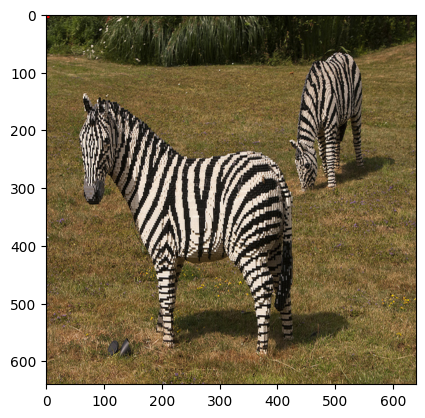

In [51]:
import matplotlib.pyplot as plt

plt.imshow(image_pil)